In [1]:
import os
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import sys
import torch
from torch.utils.data import random_split, Dataset, DataLoader
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import math
import wandb
import yaml
import zarr
from scipy.fft import rfft
import seaborn as sns

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from lab_scripts.constellation_diagram import RingShapedConstellation, get_constellation, QPSK_Constellation
from modules.models import TCN_channel, TCN, memory_polynomial_channel
from modules.utils import *

if wandb.run is not None:
    wandb.run.tags = list(wandb.run.tags) + ["junk"]
wandb.finish()

c:\Users\maild\miniconda3\envs\mldrivenpeled\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''
Import and cache dataset for fast loading in future
'''

# file_path = "../data/channel_measurements/zarr_files/channel_3e5-15MHz_3.5V_scale2.zarr"
file_path = "../data/channel_measurements/zarr_files/channel_3e5-8.6MHz_2.7V_scale2_dynamic_power_0.5-3.zarr"
file_path = r"..\data\channel_measurements\zarr_files\channel_3e5-7.6MHz_2.65.V_0.126A_scale2_dynamic_power_0.5-3.zarr"


if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = torch.device("mps") # for M chip Macs
else:
    DEVICE = torch.device("cpu")
print("DEVICE", DEVICE)

ofdm_info = extract_zarr_data(file_path, DEVICE)
sent_frames_time = ofdm_info.sent_frames_time
received_frames_time = ofdm_info.received_frames_time
dataset = ChannelData(sent_frames_time, received_frames_time, ofdm_info.FREQUENCIES)

# Split sizes
train_size = int(0.9 * len(dataset))
 

val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

# Perform split
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator()
)
print("Train Size", train_size)

DEVICE cuda


c:\Users\maild\mldrivenpeled\modules\utils.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(cache_path, map_location=device)


Loaded from cache!
Train Size 4486


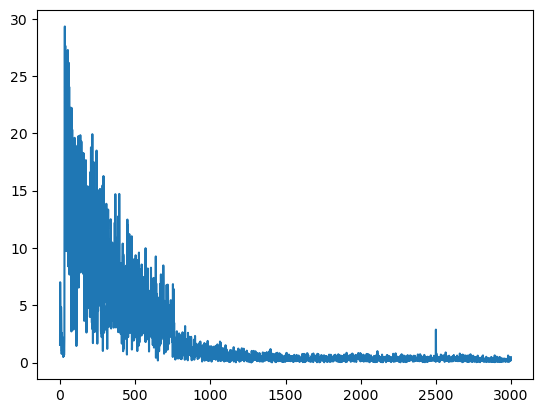

In [3]:
t = torch.fft.fft(received_frames_time[0, ofdm_info.CP_LENGTH:].cpu()).abs()
plt.plot(t[:len(t)//2])

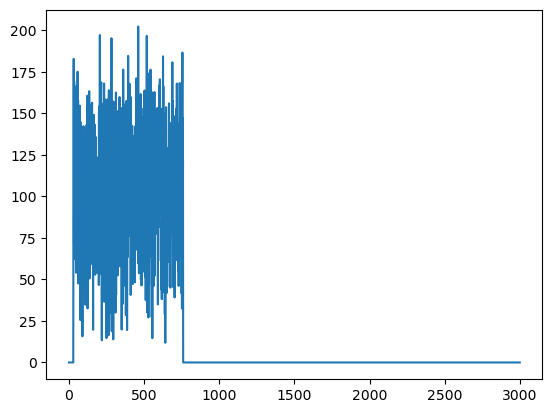

In [4]:
t = torch.fft.fft(sent_frames_time[0, ofdm_info.CP_LENGTH:].cpu()).abs()
plt.plot(t[:len(t)//2])

In [5]:
def calculate_rmse_pct_loss(y, y_pred):
    r = y - y_pred
    return (torch.sqrt(torch.mean(r ** 2) / torch.mean(y ** 2)) * 100).item()

def train(model, optimizer, loss_fn, loop, log_to_wandb=True):
    model.train()
    total_loss = 0
    batch_count = 0
    for batch in loop:
        x, y = batch[0], batch[1]
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        noisy_y_pred, y_pred, y_pred_std, y_pred_nu = model(x)
        # calculate residual
        r = y - y_pred
        if model.learn_noise:
            if model.gaussian:
                loss = loss_fn(r, y_pred_std)
            else:
                loss = loss_fn(r, y_pred_std, y_pred_nu)
        else:
            loss = loss_fn(y, y_pred)

        mse_loss = F.mse_loss(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        lr = optimizer.param_groups[0]["lr"]
        if log_to_wandb:
            wandb.log({"nnl_train_loss": loss.item()})
            wandb.log({"mse_train_loss": mse_loss.item()})
            wandb.log({"learning_rate": lr})
        batch_count += 1
        loop.set_postfix(loss=loss.item())
    loop.close()

def val(model,
        loss_fn,
        val_loader,
        ofdm_info: OFDM_channel,
        memory_polynomial=None,
        log_to_wandb=True):
    model.eval()
    val_loss = 0
    batch_count = 0
    y_preds = []
    std_preds = []
    nu_preds = []
    true_ys = []
    noisy_ys = []
    val_mse_loss = 0
    nrmse_pct_loss = 0.0
    mse_mem_loss = 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            noisy_y, mean_y, std_y, nu_y = model(x)
            y_preds.append(mean_y)
            std_preds.append(std_y)
            nu_preds.append(nu_y)
            true_ys.append(y)
            noisy_ys.append(noisy_y)
            if model.learn_noise:
                if model.gaussian:
                    loss = loss_fn(y - mean_y, std_y) # Use mean for validation
                else:
                    loss = loss_fn(y - mean_y, std_y, nu_y) # Use mean for validation
            else:
                loss = loss_fn(y, mean_y)
            mse_loss = F.mse_loss(y, mean_y)
            nrmse_pct_loss += calculate_rmse_pct_loss(y, mean_y)
            val_mse_loss += mse_loss.item()
            val_loss += loss.item()
            if memory_polynomial:
                y_pred_mp = memory_polynomial(x)
                mse_mem_loss += calculate_rmse_pct_loss(y, y_pred_mp)
            batch_count += 1

    avg_val_loss = (val_loss / batch_count)
    avg_val_mse_loss = (val_mse_loss / batch_count)
    avg_val_mem_loss = (mse_mem_loss / batch_count)
    avg_nrmse_pct_loss = (nrmse_pct_loss / batch_count)

    y_preds = torch.vstack(y_preds)
    std_preds = torch.vstack(std_preds)
    nu_preds = torch.vstack(nu_preds)
    true_ys = torch.vstack(true_ys)
    noisy_ys = torch.vstack(noisy_ys)

    if log_to_wandb:
        # Log both scalar and histogram
        wandb.log({
            'val_nll_loss': avg_val_loss,
            "avg_val_mse_loss": avg_val_mse_loss,
            "avg_nrmse_pct_loss": avg_nrmse_pct_loss
        })
        if memory_polynomial:
            wandb.log({
                'val_mem_poly_nrmse_pct_loss': avg_val_mem_loss
            })
        if model.learn_noise:
            log_snr_plots(y_preds, noisy_ys, ofdm_info)

    return avg_val_loss

In [8]:
def students_t_loss(difference, y_pred_std, y_pred_nu):
    # nu = y_pred_nu.clamp_min(2.0)
    nu = y_pred_nu
    z_resid = (difference) / (y_pred_std)
    term1 = -1 * torch.lgamma((nu + 1) / 2) + 0.5 * torch.log(torch.pi * nu) + torch.lgamma(nu / 2) + torch.log(y_pred_std + 1e-8)
    term2 = ((nu + 1) / 2) * torch.log(1 + (1 / nu) * torch.square(z_resid) + 1e-8)
    loss = torch.mean(term1 + term2)
    if torch.isnan(loss):
        raise ValueError("NaN in loss")
    return loss

def gaussian_nll(difference, y_pred_std):
    term1 = 0.5 * torch.log(2 * torch.pi * (y_pred_std ** 2))
    term2 = 0.5 * torch.square((difference) / y_pred_std)
    loss = torch.mean(term1 + term2)
    if torch.isnan(loss):
        raise ValueError("NaN in loss")
    return loss

def get_hyperparam_dict(name):
    script_dir = os.getcwd()
    config_path = os.path.join(script_dir, "..", f"configs/{name}")
    with open(config_path, "r") as f:
        hyper_dict = yaml.safe_load(f)
        return hyper_dict

hyper_dict = get_hyperparam_dict("offline_time_channel_config.yml")

# Start Weights and Biases session
wandb.init(project="mldrivenpeled",
           config=hyper_dict,
           tags=['channel_model'])
config = wandb.config

print("WandB run info:")
print(f"  Name: {wandb.run.name}")
print(f"  ID: {wandb.run.id}")
print(f"  URL: {wandb.run.url}")
print("Chosen hyperparameters for this session:")
print(config)

# Create dataloader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=config.batch_size, drop_last=False)
test_loader = DataLoader(test_dataset)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=config.batch_size, drop_last=False)

channel_model = TCN_channel(
    nlayers=config.nlayers,
    dilation_base=config.dilation_base,
    num_taps=config.num_taps,
    hidden_channels=config.hidden_channels,
    learn_noise=config.learn_noise,
    gaussian=config.gaussian
).to(DEVICE)

# Fit memory polynomial for reference
train_indices = train_dataset.indices
memory_polynomial = memory_polynomial_channel(weights=None, memory_linear=10, memory_nonlinear=10, nonlinearity_order=2, device=DEVICE)
memory_polynomial.fit(dataset.sent[train_indices], dataset.received[train_indices])
initial_model_state = copy.deepcopy(channel_model.state_dict())

if channel_model.gaussian:
    loss_fn = gaussian_nll
else:
    loss_fn = students_t_loss

optimizer = optim.AdamW(
        channel_model.parameters(),
        lr=float(config.lr),
        weight_decay=float(config.wd)
    )

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)

epoch_counter = 0
for epoch in range(config.epochs):
    epoch_counter += 1

    loop = tqdm(train_loader, desc=f'Epoch {epoch_counter}')
    train(channel_model,
            optimizer,
            loss_fn,
            loop)

    avg_val_loss = val(channel_model,
                        loss_fn,
                        val_loader,
                        memory_polynomial=memory_polynomial,
                        ofdm_info=ofdm_info)

    scheduler.step(avg_val_loss)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(channel_model)}")
# Freeze model
for param in channel_model.parameters():
    param.requires_grad = False

# Save model
torch.save({
    "channel_model": channel_model.state_dict(),
}, "../models/channel_models/channel_model_final.pth")

artifact = wandb.Artifact("channel_model", type="model")
artifact.add_file("../models/channel_models/channel_model_final.pth")
logged_artifact = wandb.log_artifact(artifact)

# Get version from server for next stage
logged_artifact.wait()

channel_model_version = logged_artifact.version
print("Finished!")
channel_run_name = wandb.run.name
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


WandB run info:
  Name: ruby-morning-8019
  ID: nvcwpvko
  URL: https://wandb.ai/dylanbackprops-university-of-washington/mldrivenpeled/runs/nvcwpvko
Chosen hyperparameters for this session:
{'CP_ratio': 0.25, 'batch_size': 16, 'num_taps': 10, 'epochs': 10, 'gain': 20, 'lr': 0.001, 'wd': '1e-2', 'nlayers': 1, 'hidden_channels': 16, 'dilation_base': 2, 'num_points_symbol': 4000, 'learn_noise': True, 'scheduler_type': 'reduce_lr_on_plateu', 'weight_init': 'default', 'gaussian': False, 'Nf': 1499, 'Nt': 1, 'flow': 300000, 'fhigh': '8.6e6', 'fnyquist': '30e6', 'subcarrier_spacing': '1e4'}


Epoch 10: 100%|██████████| 281/281 [00:02<00:00, 100.71it/s, loss=-3.12]


Trainable parameters: 259
Finished!


avg_nrmse_pct_loss,█▃▂▂▂▂▁▁▁▁
avg_val_mse_loss,█▂▂▂▂▂▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse_train_loss,▄█▂▃▃▂▂▂▂▂▂▁▂▃▂▁▁▄▂▃▂▂▂▂▁▂▁▂▂▂▂▂▁▁▂▂▁▁▁▃
nnl_train_loss,█▅▇▃▄▄▄▁▄▄▃▄▂▂▃▃▃▂▃▂▂▂▂▃▂▁▂▂▄▂▂▃▂▄▃▃▃▂▂▂
val_mem_poly_nrmse_pct_loss,▁▁▁▁▁▁▁▁▁▁
val_nll_loss,█▂▂▂▁▁▁▁▁▁
avg_nrmse_pct_loss,20.95479
avg_val_mse_loss,0.00017
learning_rate,0.001
mse_train_loss,0.00016


### Memory Polynomial for Comparison

In [9]:
TCN_CHANNEL = True
if TCN_CHANNEL:
    api = wandb.Api()
    # run = api.run("dylanbackprops-university-of-washington/mldrivenpeled/oibih492") # Variable
    model_name = "channel_model_final"
    # artifact = api.artifact("dylanbackprops-university-of-washington/mldrivenpeled/channel_model:v581") # Variable

    entity = "dylanbackprops-university-of-washington"
    project = "mldrivenpeled"
    artifact_name = "channel_model"
    version = channel_model_version

    # Construct the full path string
    channel_model_artifact_path = f"{entity}/{project}/{artifact_name}:{version}"
    artifact = api.artifact(channel_model_artifact_path)
    artifact_dir = artifact.download() # downloads to CWD

    logging_run = artifact.logged_by()

    remote_config = logging_run.config

    run_name = logging_run.name
    print("Channel Run name:", run_name)

    channel_model = TCN_channel(
        nlayers=remote_config['nlayers'],
        dilation_base=remote_config['dilation_base'],
        num_taps=remote_config['num_taps'],
        hidden_channels=remote_config['hidden_channels'],
        learn_noise=remote_config['learn_noise'],
        gaussian=remote_config['gaussian']
    ).to(DEVICE)

    channel_model_path = os.path.join(artifact_dir, model_name + ".pth")
    checkpoint = torch.load(channel_model_path)
    channel_model.load_state_dict(checkpoint["channel_model"])
else:
    run_name = "Trained on MP channel model"
    channel_model = memory_polynomial_channel(weights=None, memory_linear=10, memory_nonlinear=10, nonlinearity_order=2, device=DEVICE)
    weights, A, residuals = channel_model.fit(sent_frames_time, received_frames_time)
    terms, weights = channel_model.show_terms()


# Freeze before moving to DEVICE
for param in channel_model.parameters():
    param.requires_grad = False


channel_model = channel_model.to(DEVICE).float()
channel_model.eval()


wandb:   1 of 1 files downloaded.  


Channel Run name: ruby-morning-8019


C:\Users\maild\AppData\Local\Temp\ipykernel_22336\564895984.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(channel_model_path)


TCN_channel(
  (tcn): Sequential(
    (0): TCNBlock(
      (conv): Conv1d(1, 16, kernel_size=(10,), stride=(1,))
      (relu): ReLU()
      (resample): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
    )
  )
  (readout): Conv1d(16, 3, kernel_size=(1,), stride=(1,))
)

In [ ]:
memory_polynomial = memory_polynomial_channel(weights=None, memory_linear=10, memory_nonlinear=10, nonlinearity_order=2, device=DEVICE)
memory_polynomial.fit(sent_frames_time, received_frames_time)
_ = memory_polynomial.show_terms(plot=True)

In [ ]:
_ = memory_polynomial.calculate_err(sent_frames_time, received_frames_time, plot=True)

--------------------------------------------------
Rank  | Term String          | ERR (%)        
--------------------------------------------------
1     | x[0]                 | 50.499462%
2     | x[-1]                | 20.150345%
3     | x[-2]                | 11.350628%
4     | x[-3]                | 4.374449%
5     | x[-4]                | 2.343153%
6     | x[-5]                | 1.506910%
7     | x[0]^2               | 1.364028%
8     | x[-6]                | 1.043040%
9     | x[-7]                | 0.632540%
10    | x[-4]^2              | 0.481117%
11    | x[-1]^2              | 0.440389%
12    | x[-8]                | 0.393167%
13    | x[-5]^2              | 0.361668%
14    | x[-3]^2              | 0.294651%
15    | x[-9]                | 0.261631%
16    | x[-6]^2              | 0.204194%
17    | x[-10]               | 0.172314%
18    | x[-2]^2              | 0.159769%
19    | x[-11]               | 0.119738%
20    | x[-7]^2              | 0.116960%
21    | x[-12]              

In [ ]:
print("Channel model parameters frozen:",
      all(not param.requires_grad for param in channel_model.parameters()))

constellation_mode = "m7_apsk_constellation"

constellation = get_constellation(constellation_mode)

script_dir = os.getcwd()
config_path = os.path.join(script_dir, "..", "configs/offline_time_ae_config.yml")
with open(config_path, "r") as f:
    hyperparams = yaml.safe_load(f)

    wandb.init(project="mldrivenpeled",
            config=hyperparams,
            tags=['autoencoder'])
    config = wandb.config
    if wandb.run.notes is None:
        wandb.run.notes = ""
    config.modulator = constellation_mode
    wandb.run.notes += wandb.run.notes + f"\n | trained on channel model {run_name} \n | {constellation_mode}"
    print("WandB run info:")
    print(f"  Name: {wandb.run.name}")
    print(f"  ID: {wandb.run.id}")
    print(f"  URL: {wandb.run.url}")
    print("Chosen hyperparameters for this session:")
    print(config)

encoder = TCN(
    nlayers=config.nlayers,
    dilation_base=config.dilation_base,
    num_taps=config.num_taps,
    hidden_channels=config.hidden_channels,
).to(DEVICE)

decoder = TCN(
    nlayers=config.nlayers,
    dilation_base=config.dilation_base,
    num_taps=config.num_taps,
    hidden_channels=config.hidden_channels
).to(DEVICE)

optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=config.lr, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, min_lr=1e-6)


val_ofdm_settings = OFDM_channel()

NUM_BITS = config.Nt * config.Nf * constellation.modulation_order

FREQUENCIES = torch.arange(
    float(config.flow),
    float(config.fhigh),
    float(config.subcarrier_spacing)
)

delta_f = FREQUENCIES[1] - FREQUENCIES[0]
KS = (FREQUENCIES / delta_f).to(torch.int)

K_MIN = int(KS[0].item())
K_MAX = int(KS[-1].item())
NUM_POS_FREQS = K_MAX + 1
RIGHT_PADDING_ZEROS = (ofdm_info.NUM_POINTS_FRAME - 2 *  NUM_POS_FREQS) // 2
LEFT_PADDING_ZEROS = K_MIN - 1
PREAMBLE_MAX = config.preamble_amplitude

val_ofdm_settings = OFDM_channel(
    FREQUENCIES=FREQUENCIES,
    NUM_POINTS_SYMBOL=config.Nf,
    CP_LENGTH=ofdm_info.CP_LENGTH,
    DELTA_K=int(delta_f.item()),
    KS=KS,
    K_MIN=K_MIN,
    K_MAX=K_MAX,
    LEFT_PADDING_ZEROS=LEFT_PADDING_ZEROS,
    CP_RATIO=ofdm_info.CP_RATIO,
    NUM_POINTS_FRAME=ofdm_info.NUM_POINTS_FRAME,
    NUM_POS_FREQS=len(KS),
    RIGHT_PADDING_ZEROS=RIGHT_PADDING_ZEROS
)

def train(channel_model, encoder, decoder, optimizer, scheduler, config, DEVICE, mask=None):

    encoder = encoder.to(DEVICE)
    decoder = decoder.to(DEVICE)

    average_encoded_power = 0.0
    for epoch in range(config["epochs"]):
        encoder.train()
        decoder.train()
        epoch_loss = 0
        epoch_freq_loss = 0
        optimizer.zero_grad()
        batch_entries = []
        true_bits_list = []
        for batch in range(config["batch_size"]):
            # Generate frame data
            true_bits = np.random.randint(0, 2, size=NUM_BITS)
            true_bits_list.append(torch.tensor(true_bits))
            true_bits_str = ''.join(map(str, true_bits))
            true_symbols = torch.tensor(
                constellation.bits_to_symbols(true_bits_str),
                dtype=torch.complex64, device=DEVICE
            )
            true_frame = true_symbols.reshape(config["Nt"], config["Nf"])


            batch_entries.append(true_frame)

        true_bits = torch.stack(true_bits_list)

        # Batch along time domain
        true_frame = torch.cat(batch_entries)

        # print("Inband symbol power", true_frame.abs().square().mean())
        # Convert to time domain
        sent_frames_time = symbols_to_time(true_frame, val_ofdm_settings.LEFT_PADDING_ZEROS, val_ofdm_settings.RIGHT_PADDING_ZEROS)
        sent_frames_time = torch.hstack((sent_frames_time[:, -val_ofdm_settings.CP_LENGTH:], sent_frames_time))

        # print(f"Encoder Ave Pwr In {sent_frames_time.square().mean().item(): .3f}")
        encoded_frames_time = encoder(sent_frames_time)
        average_encoded_power += encoded_frames_time.square().mean().item()

        # print(f"Encoder Ave Pwr Out {encoded_frames_time.square().mean().item(): .3f}")

        # encoded_frames_time = in_band_filter(encoded_frames_time, KS, NUM_POINTS_FRAME)

        # Clip to preamble make
        encoded_frames_time = torch.clip(encoded_frames_time, -PREAMBLE_MAX, PREAMBLE_MAX)

        if TCN_CHANNEL:
            received_frames_time, mean, std, nu = channel_model(encoded_frames_time)
            if torch.isnan(received_frames_time).any():
                raise ValueError("NaN in Loss!")
        else:
            received_frames_time = channel_model(encoded_frames_time)
            mean = received_frames_time
            std = 0
            nu = 0


        decoded_frames_time = decoder(received_frames_time)

        # Convert to frequency domain for loss
        sent_frames_frequency = torch.tensor(rfft(sent_frames_time[:, val_ofdm_settings.CP_LENGTH:].detach().cpu().numpy(), norm='ortho', axis=1)[:, KS])
        decoded_frames_frequency = torch.tensor(rfft(decoded_frames_time[:, val_ofdm_settings.CP_LENGTH:].detach().cpu().numpy(), norm='ortho', axis=1)[:, KS])

        loss = in_band_time_loss(sent_frames_time, decoded_frames_time, ks_indices=KS, n_fft=val_ofdm_settings.NUM_POINTS_FRAME, num_taps=config['num_taps'])


        diff_complex = sent_frames_frequency.detach() - decoded_frames_frequency.detach()
        freq_loss = torch.mean(diff_complex.abs().pow(2))
        loss.backward()
        epoch_loss += loss.item()
        epoch_freq_loss += freq_loss.item()


        optimizer.step()
        scheduler.step(epoch_loss)

        wandb.log({"loss": epoch_loss}, step=epoch)
        wandb.log({"freq_loss": epoch_freq_loss}, step=epoch)
        lr = optimizer.param_groups[0]["lr"]
        wandb.log({"learning_rate": lr}, step=epoch)

        # Get BER
        ber = calculate_BER(decoded_frames_frequency.detach().flatten(), true_bits.flatten(), constellation=constellation)
        wandb.log({"BER": ber}, step=epoch)

        if epoch % 5 == 0:
            make_time_validate_plots(
            sent_frames_time[0],
            encoded_frames_time[0],
            received_frames_time[0],
            decoded_frames_time[0],
            frame_BER=ber,
            run_model=True,
            step=epoch
            )

            # Plot first example of sent and reconstructed time
            fig, ax = plt.subplots()
            ax.plot(sent_frames_time[0][:100].detach().cpu().numpy(), label="Sent (time)")
            ax.plot(decoded_frames_time[0][:100].detach().cpu().numpy(), label="Decoded (time)")
            ax.legend()
            ax.set_title(f"Sent vs Decoded (Time Domain) EVM: {loss: 0.3e}")
            wandb.log({"time_domain_plot": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            sent_symbols = sent_frames_frequency[0].detach().cpu().numpy()
            decoded_symbols = decoded_frames_frequency[0].detach().cpu().numpy()

            # Compute EVM for logging (per frame)
            evm_val = evm_loss(torch.tensor(sent_symbols), torch.tensor(decoded_symbols)).item()

            # Create constellation plot
            fig, ax = plt.subplots()
            ax.scatter(sent_symbols.real, sent_symbols.imag, color='blue', alpha=0.6, label='Sent')
            ax.scatter(decoded_symbols.real, decoded_symbols.imag, color='red', alpha=0.6, label='Decoded')
            ax.set_xlabel('In-phase')
            ax.set_ylabel('Quadrature')
            ax.set_title(f'Constellation Diagram EVM: {evm_val:0.3e}')
            ax.legend()
            ax.grid(True)

            # Log to wandb
            wandb.log({"constellation": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            evm_per_freq = ((sent_frames_frequency[0] - decoded_frames_frequency[0]).abs()**2).detach().cpu().numpy()
            fig, ax = plt.subplots()
            ax.plot(evm_per_freq)
            ax.set_title("EVM vs Frequency")
            wandb.log({"evm_vs_freq": wandb.Image(fig)}, step=epoch)
            plt.close(fig)


            # Plot Model SNRs
            sent_k = torch.fft.fft(encoded_frames_time[:, val_ofdm_settings.CP_LENGTH:], norm="ortho", dim=-1)
            received_k = torch.fft.fft(mean[:, val_ofdm_settings.CP_LENGTH:], norm="ortho", dim=-1)

            residual = received_frames_time - mean
            received_noise_k = torch.fft.fft(residual[:, val_ofdm_settings.CP_LENGTH:] ** 2, norm="ortho", dim=-1)


            signal_power = torch.mean(torch.abs(sent_k) ** 2, dim=0).detach().cpu().numpy()
            received_power = torch.mean(torch.abs(received_k) ** 2, dim=0).detach().cpu().numpy()
            received_noise_power = torch.mean(torch.abs(received_noise_k), dim=0).detach().cpu().numpy()
            snr_vs_freq = (received_power / received_noise_power + 1e-12)

            fig, ax = plt.subplots()
            ax.plot(10 * np.log10(signal_power[:len(signal_power)//2]))
            ax.axvline(30, c='r', linestyle='--')
            ax.axvline(int(4e2), c='r', linestyle='--')
            ax.set_title("Encoded Signal Frequency Power Spectrum")
            ax.set_xlabel("Freq Index k (10 kHz)")
            ax.set_ylabel("Power (dB)")
            wandb.log({"encoded_signal_power_spectrum": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            fig, ax = plt.subplots()
            ax.plot(10 * np.log10(received_power[:len(received_power)//2]))
            ax.axvline(30, c='r', linestyle='--')
            ax.axvline(int(4e2), c='r', linestyle='--')
            ax.set_title("Received Signal Frequency Power Spectrum")
            ax.set_xlabel("Freq Index k (10 kHz)")
            ax.set_ylabel("Power (dB)")
            wandb.log({"received_signal_power_spectrum": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            fig, ax = plt.subplots()
            ax.plot(10 * np.log10(snr_vs_freq[:len(snr_vs_freq)//2]))
            ax.set_title("SNR vs Freq Estimate")
            ax.set_xlabel("Freq Index k (10 kHz)")
            ax.set_ylabel("SNR (dB)")
            ax.axvline(30, c='r', linestyle='--')
            ax.axvline(int(4e2), c='r', linestyle='--')
            wandb.log({"snr_vs_freq": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            fig, ax = plt.subplots()
            ax.plot(10 * np.log10(received_noise_power[:len(snr_vs_freq)//2]))
            ax.set_title("Noise power vs Freq Estimate")
            ax.set_xlabel("Freq Index k (10 kHz)")
            ax.set_ylabel("Power (dB)")
            ax.axvline(30, c='r', linestyle='--')
            ax.axvline(int(4e2), c='r', linestyle='--')
            wandb.log({"noise_power_vs_freq": wandb.Image(fig)}, step=epoch)
            plt.close(fig)
    average_encoded_power /= config['epochs']


    # Save model
    torch.save({
        "time_encoder": encoder.state_dict(),
        "time_decoder": decoder.state_dict()
    }, "time_autoencoder.pth")

    artifact = wandb.Artifact("time_autoencoder", type="model")
    artifact.add_file("time_autoencoder.pth")
    wandb.log_artifact(artifact)

    return epoch_loss, average_encoded_power

_, average_enc_power = train(channel_model, encoder, decoder, optimizer, scheduler, config, DEVICE)
wandb.finish()
print(average_enc_power)

Channel model parameters frozen: True


WandB run info:
  Name: honest-sun-8016
  ID: 01guok13
  URL: https://wandb.ai/dylanbackprops-university-of-washington/mldrivenpeled/runs/01guok13
Chosen hyperparameters for this session:
{'CP_ratio': 0.25, 'batch_size': 16, 'dc_offset': 0, 'num_taps': 10, 'epochs': 750, 'gain': 20, 'lr': 0.001, 'nlayers': 2, 'hidden_channels': 16, 'dilation_base': 2, 'preamble_amplitude': 3, 'num_symbols_per_frame': 1, 'scheduler_type': 'reduce_lr_on_plateu', 'weight_init': 'default', 'Nf': 830, 'Nt': 1, 'flow': 300000, 'fhigh': '8.6e6', 'subcarrier_spacing': '1e4', 'modulator': 'm7_apsk_constellation'}


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


BER,█▇▇▆▆▆▅▅▅▄▄▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
freq_loss,█▇▇▆▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,███████████████████████████████▃▃▃▃▂▂▂▂▁
loss,███▆▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time_frame_BER,█████▇▇▅▄▄▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time_mse_loss,██▇▇▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
BER,0.10293
freq_loss,0.01158
learning_rate,3e-05
loss,0.00322
time_frame_BER,0.10461


1.3656071525265774
